# Capacitance Model and Charge-Stability Diagrams

This notebook deals with the simulation of a bare bones capacitance model for a N dot system. The capacitances are set before the simulation and are not calculated from an underlying theory.

The basic goal of this notebook is to produce a honeycomb diagram for a double dot system.



Calculation finished in 81.70696806907654 seconds.


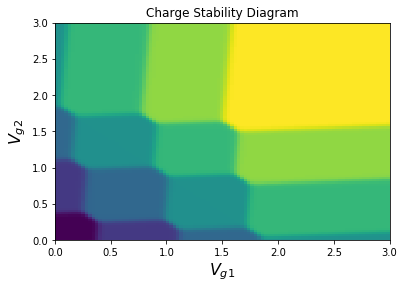

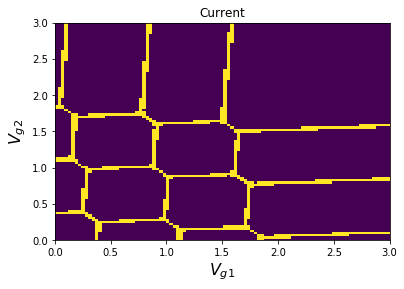

In [123]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools

# Number of dots in the system
N_dot = 2

# define the capacitances
# the dot capacitance, assumed to be equal for all dots
C_dot = 2.5
# inter-dot cross capacitance, assumed to be equal for all dots
C_dot_cross = 0.5

# gate capacitance, assumed to equal for all gates
C_g = 1.4
C_g_cross = 0.2


# The dots are assumed to be in a linear geometry. Hence, the cross capacitance acts only between adjacent dots.
def calc_cap_matrix(N_dot,C_diag,C_cross):
    C_mat = np.diag(C_diag*np.ones(N_dot),k = 0) + \
            np.diag(C_cross*np.ones(N_dot-1),k = 1) + \
            np.diag(C_cross*np.ones(N_dot-1),k = -1) 
    return C_mat

C_mat_dot = calc_cap_matrix(N_dot,C_dot,C_dot_cross)
C_mat_gate = calc_cap_matrix(N_dot,C_g,C_g_cross)

def calc_U(N_vec,V_g_vec,C_mat_dot,C_mat_gate): 
    # -1.0 because electron charge is negative
    Q_vec = -1.0 * N_vec + np.dot(C_mat_gate,V_g_vec) 
    
    # We solve the linear system Q = C V, where V contains the unknown electrochemical potentials U
    U_vec = np.linalg.solve(C_mat_dot,Q_vec)
    
    U = 0.5 * np.dot(U_vec,np.dot(C_mat_dot,U_vec.T))
    return U

def fermi(E,kT):
    return 1.0/(1.0 + np.exp(E/kT)) 

def calc_weight(a,b,V_g_vec,C_mat_dot,C_mat_gate,kT):
    N_dot = len(a)
    if list(abs(np.array(a) - np.array(b))) in [list(x) for x in list(np.eye(N_dot,dtype=np.int))]:
        U_a = calc_U(np.array(a),V_g_vec,C_mat_dot,C_mat_gate)
        U_b = calc_U(np.array(b),V_g_vec,C_mat_dot,C_mat_gate)
        # notice the order, calc_weight calculates the weight to go from a to b
        return fermi(U_b - U_a,kT)
    else:
        return 0.0

def calc_charge(N_dot,V_g_vec,C_mat_dot,C_mat_gate,kT):
   
    E_max = 4
    # create the array with all possible electronic states on dots
    states = list(itertools.product(*[list(range(E_max))]*N_dot)) 
    
    # A : adjacency matrix between the possible states, two states are connected only by a single electron tunneling event
    A = np.array([calc_weight(a,b,V_g_vec,C_mat_dot,C_mat_gate,kT) for a in states for b in states])\
        .reshape((len(states),len(states)))

    M = A.T - np.diag(np.sum(A,axis=1))

    # append the normalisation condition, and drop ones of the rows of M
    M_solver = np.append(M[:-1,:],[np.ones(M.shape[0])]).reshape(M.shape)

    # RHS in the master equation solution, the last element is the prob. normalisation condition
    b = np.zeros(M.shape[0])
    b[-1] = 1
    P = np.linalg.solve(M_solver,b)
    #state = states[np.argmax(P)]
    
    state = np.sum(np.array([x*np.array(y) for (x,y) in zip(P,states)]),axis=0)
   
    # poor's man current model
    # smart trick, current is finite over kT range
    if np.any([abs(x-0.5) < 25*kT for x in P]):
        current = 1
    else:
        current = 0
    return state,current

kT = 1e-2
N_v = 100
V_g_vec = np.linspace(0,3,N_v)
V_g_arr = list(itertools.product(*[list(V_g_vec)]*N_dot))

import time
st = time.time()
charge = [calc_charge(N_dot,x,C_mat_dot,C_mat_gate,kT) for x in V_g_arr]
print("Calculation finished in",time.time()-st,"seconds.")

# specific to 2 dot
XX,YY = np.meshgrid(V_g_vec,V_g_vec)
plt.figure(1)
plt.pcolor(XX,YY,np.array([np.sum(x[0]) for x in charge]).reshape(N_v,N_v))
plt.xlabel(r"$V_{g1}$",fontsize=16)
plt.ylabel(r"$V_{g2}$",fontsize=16)
plt.title("Charge Stability Diagram")
plt.figure(2)
plt.pcolor(XX,YY,np.array([np.sum(x[1]) for x in charge]).reshape(N_v,N_v))
plt.xlabel(r"$V_{g1}$",fontsize=16)
plt.ylabel(r"$V_{g2}$",fontsize=16)
plt.title("Current")